In [ ]:
pwd

'/content'

In [ ]:
cd 'drive/MyDrive/satellite images'

[Errno 2] No such file or directory: 'drive/MyDrive/satellite images'
/content


## Introduction

The vast amount of satellite imagery collected every day across the globe is huge. Frequent Global coverage of the Earth and high-resolution data with readily available data to the public makes it helpful in monitoring the earth and its environment.

We will learn how to access satellite images, analyze and visualize them right in Jupyter notebooks environment with python. Satellite images are pixel wised data just like any other types of images you have used. In Geography and Remote sensing terminology, this is called Rasters. Raster images mainly consist of satellite images, Lidar data as well as Georeferenced maps. As we will see, rasters consist of a matrix of cells and rows and each cell/row holds information about the location, such as elevation, temperature and vegetation.

### Aims

The aims of this lecture are to:

    - Querry, retrieve and download satellite images directly with Python in  
      Jupyter notebook.

    - Read and Write Raster images in Python.

    - Create RGB and NDVI images from Sentinel 2 Bands

    - understand applications of NDVI index in farming 

### Accessing data

We will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sentinelsat

     |████████████████████████████████| 48 kB 2.2 MB/s 


In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 30.4 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


Paste your Corpenicus Open Access Hub username and password in the code below

In [ ]:
from sentinelsat import SentinelAPI

In [ ]:
user = 'Mfundo' 
password = '970224@Sima' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

We are now all set to use sentinelsat and download Sentinel Satellite images. In this example, we will use boundary data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which we will use as a boundary to clip from the whole satellite image tile.

We will read the boundary of the natural reserve as Shapefile with Geopandas and visualize it with Folium python library

In [ ]:
import geopandas as gpd
import folium

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NaturalReserve_Polygon.cpg to NaturalReserve_Polygon.cpg
Saving NaturalReserve_Polygon.dbf to NaturalReserve_Polygon.dbf
Saving NaturalReserve_Polygon.prj to NaturalReserve_Polygon.prj
Saving NaturalReserve_Polygon.qpj to NaturalReserve_Polygon.qpj
Saving NaturalReserve_Polygon.shp to NaturalReserve_Polygon.shp
Saving NaturalReserve_Polygon.shx to NaturalReserve_Polygon.shx


In [ ]:
nReserve = gpd.read_file('NaturalReserve_Polygon.shp')

m = folium.Map([41.7023292727353, 12.34697305914639], zoom_start=12)
folium.GeoJson(nReserve).add_to(m)
m

With the above code, we have read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, we can add the Geopandas data to the base map we have created to visualize the Natural Reserve boundary we are interested in/ Below you can see the map

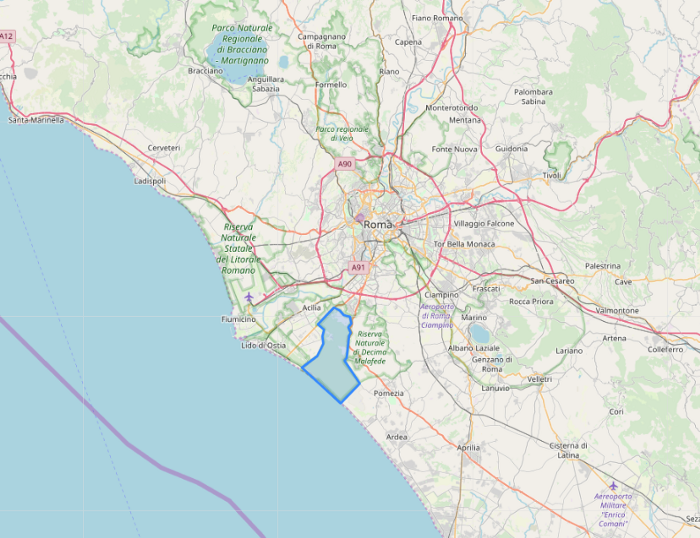

In [ ]:
from IPython.display import Image
Image('map.png')

One last step before we can search and download sentinel 2 images is to create a footprint from the nReservegeometry. Here we will use Shapely Python library since our data is in Shapefiles and have read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, sentinelsatprovides a handy way to convert your data into a proper format in the query).

In [ ]:
from shapely.geometry import MultiPolygon, Polygon

In [ ]:
footprint = None
for i in nReserve['geometry']:
    footprint = i

Now we can run a query on the apiwe have created above. There are different ways you can construct your query here depending on your use case. In this example, we will create a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (Area of study). For the time period, we are interested only in Sentinel Level 2A satellite images taken between ‘20190601’ and ‘20190626’

In [ ]:
products = api.query(footprint,
                     date = ('20190601', '20190626'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [ ]:
len(products)

6

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but we can tweak the query for a different use case example by expanding the time period or increasing the cloud coverage percentage.

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage. 


     - In comparison with plain dataframe, GeodataFrame holds the geometry of each satellite image tile. Once we create the GeodataFrame and sort it. 
     
As we do not have many products here we call directly products_gdf_sorted table to see the attributes off all 6 rows.

In [ ]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,highprobacloudspercentage,mediumprobacloudspercentage,notvegetatedpercentage,snowicepercentage,unclassifiedpercentage,vegetationpercentage,waterpercentage,format,instrumentshortname,instrumentname,s2datatakeid,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 21:54:46.895,11731,122,0.351409,0.174727,0.170985,7.815286,0.000143,0.313549,38.877469,52.508199,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1006.25 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,16e95baf-bbcb-43fe-ab67-5fecea2ffde5,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
590a4ce9-c540-4cb9-844b-3ee1efff8ca9,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 22:16:12.999,11731,122,0.397842,0.208563,0.183616,8.021347,0.000275,0.321996,40.439722,50.688905,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1009.58 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,590a4ce9-c540-4cb9-844b-3ee1efff8ca9,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
d1a70889-1d44-414c-a357-08a7185c04b4,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:50:05.133,12017,122,0.433280,0.050026,0.036984,16.288386,0.000070,0.181177,30.435181,52.569532,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190625T100039_012017_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,941.03 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,d1a70889-1d44-414c-a357-08a7185c04b4,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:48:59.153,12017,122,0.436717,0.052163,0.037989,16.863325,0.000076,0.182113,31.675929,50.751525,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190625T100039_012017_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,948.75 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
c9e76145-3270-458c-9927-49d1354be29e,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,https://scihub.copernic

In [ ]:
products_gdf_sorted.head(2)

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,highprobacloudspercentage,mediumprobacloudspercentage,notvegetatedpercentage,snowicepercentage,unclassifiedpercentage,vegetationpercentage,waterpercentage,format,instrumentshortname,instrumentname,s2datatakeid,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 21:54:46.895,11731,122,0.351409,0.174727,0.170985,7.815286,0.000143,0.313549,38.877469,52.508199,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1006.25 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,16e95baf-bbcb-43fe-ab67-5fecea2ffde5,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
590a4ce9-c540-4cb9-844b-3ee1efff8ca9,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 22:16:12.999,11731,122,0.397842,0.208563,0.183616,8.021347,0.000275,0.321996,40.439722,50.688905,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1009.58 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,590a4ce9-c540-4cb9-844b-3ee1efff8ca9,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."


       - The output shows columns of the products_gdf_sorted table. 
       
       - In the index, we have tiles which we can use to download the particular image. 
       
       - Additional columns also include a title which has the full name of the tile and some other useful columns like cloud coverage percentage.

### Exercise 1:

       - which satellite image has the least cloud coverage?

Let us say we are interested in the first satellite image, we can simply call download and provide the product name 

Note that 

         - we can download all images at once with api.download_all() function).

         - our interest in the first image is sparked by the fact that since this image has the least cloud coverage of all available images.

In [ ]:
# uncomment and run this code
#if you get an error, the reason is given in the cell below (the dates chosen are a bit old)

#api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

       - SciHub now has a rolling archive: only recent data is available for immediate download. 
       
       - Older products have to be requested from long-term archive one-by-one and can be downloaded after some waiting time (hours).

In [ ]:
prods = api.query(footprint,
                     date = ('20201201', '20201226'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [ ]:
len(prods)

6

In [ ]:
prods_gdf = api.to_geodataframe(prods)
prods_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
prods_gdf_sorted

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,cloudcoverpercentage,highprobacloudspercentage,mediumprobacloudspercentage,notvegetatedpercentage,snowicepercentage,unclassifiedpercentage,vegetationpercentage,waterpercentage,format,instrumentshortname,instrumentname,s2datatakeid,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
16e95baf-bbcb-43fe-ab67-5fecea2ffde5,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 21:54:46.895,11731,122,0.351409,0.174727,0.170985,7.815286,0.000143,0.313549,38.877469,52.508199,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1006.25 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_2...,16e95baf-bbcb-43fe-ab67-5fecea2ffde5,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
590a4ce9-c540-4cb9-844b-3ee1efff8ca9,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-05T10:00:39.024Z, Instrument: MS...",false,2019-06-05 10:00:39.024,2019-06-05 10:00:39.024,2019-06-05 22:16:12.999,11731,122,0.397842,0.208563,0.183616,8.021347,0.000275,0.321996,40.439722,50.688905,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190605T100039_011731_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,1009.58 MB,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_SGS__20190605T134619_A0117...,S2B_MSIL2A_20190605T100039_N0212_R122_T32TQM_2...,590a4ce9-c540-4cb9-844b-3ee1efff8ca9,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
d1a70889-1d44-414c-a357-08a7185c04b4,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:50:05.133,12017,122,0.433280,0.050026,0.036984,16.288386,0.000070,0.181177,30.435181,52.569532,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190625T100039_012017_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,941.03 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T33TTG_2...,d1a70889-1d44-414c-a357-08a7185c04b4,"MULTIPOLYGON (((11.41073 41.40773, 12.72303 41..."
a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-06-25T10:00:39.024Z, Instrument: MS...",false,2019-06-25 10:00:39.024,2019-06-25 10:00:39.024,2019-06-25 19:48:59.153,12017,122,0.436717,0.052163,0.037989,16.863325,0.000076,0.182113,31.675929,50.751525,SAFE,MSI,Multi-Spectral Instrument,GS2B_20190625T100039_012017_N02.12,2017-013A,DESCENDING,Sentinel-2B,02.12,Level-2A,S2MSI2A,Sentinel-2,948.75 MB,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190625T123721_A0120...,S2B_MSIL2A_20190625T100039_N0212_R122_T32TQM_2...,a24e1e2c-da6a-4f2b-b19b-b97cfe4fbbe8,"MULTIPOLYGON (((12.70556 41.40403, 12.76314 42..."
c9e76145-3270-458c-9927-49d1354be29e,S2A_MSIL2A_20190620T100031_N0212_R122_T32TQM_2...,https://scihub.copernic

In [ ]:
api.download("16e95baf-bbcb-43fe-ab67-5fecea2ffde5")

LTATriggered: ignored

Downloading this file will take a while (Sentinel 2 Satellite image tiles are about 1 GB). Once the download is finished, we can simply unzip it.

### Exploring Satellite Imagery with Rasterio

Once we unzip the downloaded folder, we get many subfolders and it is sometimes hard to navigate through these folders. Here is a tree of the folders.

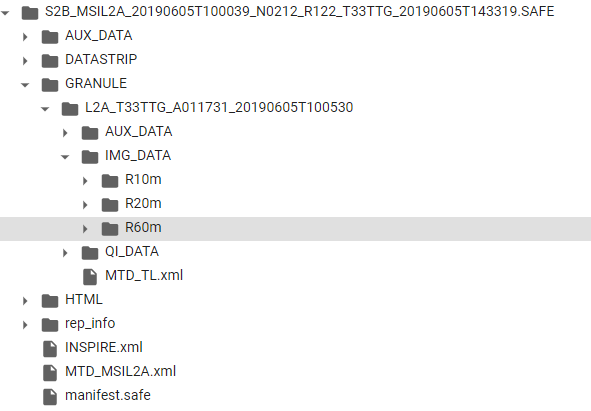

In [ ]:
Image('tree_folder.png')

Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. While there are other higher resolution satellites available(1m to 0.5 cm), Sentinel-2 data is free and has a high revisit time (5 days) which makes it an excellent option to study environmental challenges. Here is a useful table for sentinel 2 bands colours.

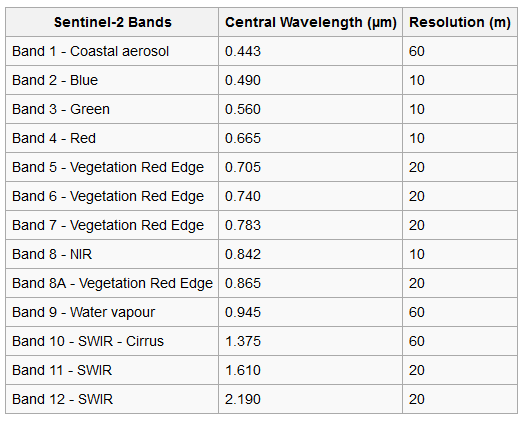

In [ ]:
Image('tbl.png')

### Create RGB Image

The true colour of satellite images is often displayed in a combination of the red, green and blue bands. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 4.7 MB/s 


In [ ]:
import rasterio as rio
from rasterio.plot import show

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving INSPIRE.xml to INSPIRE.xml
Saving manifest.safe to manifest.safe
Saving MTD_MSIL2A.xml to MTD_MSIL2A.xml


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving T33TTG_20190605T100039_AOT_10m.jp2 to T33TTG_20190605T100039_AOT_10m.jp2
Saving T33TTG_20190605T100039_B02_10m.jp2 to T33TTG_20190605T100039_B02_10m.jp2
Saving T33TTG_20190605T100039_B03_10m.jp2 to T33TTG_20190605T100039_B03_10m.jp2
Saving T33TTG_20190605T100039_B04_10m.jp2 to T33TTG_20190605T100039_B04_10m.jp2


In [ ]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')


# Create an RGB image 
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

RasterioIOError: ignored

We open an empty RGB.tiff in Rasterio with the same parameters — i.e. 

      width, height, CRS, etc.. 
      
of Band 4 ( You can choose any of the three bands). 

Then we need to write those bands to the empty RGB image.

### Exercise 2

    Display the RGB image. Your output should be similar to the diagram below

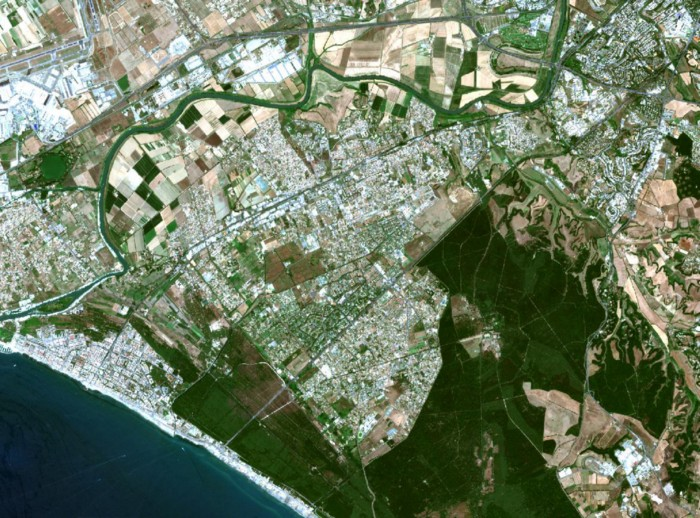

In [ ]:
Image('rgb_img.jpeg')

### Clip Satellite images

         - One important preprocessing task to clip or mask an area of study. 
          
         - Since this RGB image is large and huge, we can save both computing 
           power and time when we clip and then use only the area of interest. 
         
         - We will clip the Natural reserve area from the RGB image.

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
from rasterio import mask as msk 

In [ ]:
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = msk.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NameError: ignored

           - Here, we first reproject our Natural reserve with the same projection as the original image. 
           
           - Next, we open the RGB image, get the metadata and mask with the projected boundary.

          -  The result is only the masked/clipped area of interest as shown in the below image.

### Exercise 3

      - Display the masked image. Your output should be similar to the diagram given below

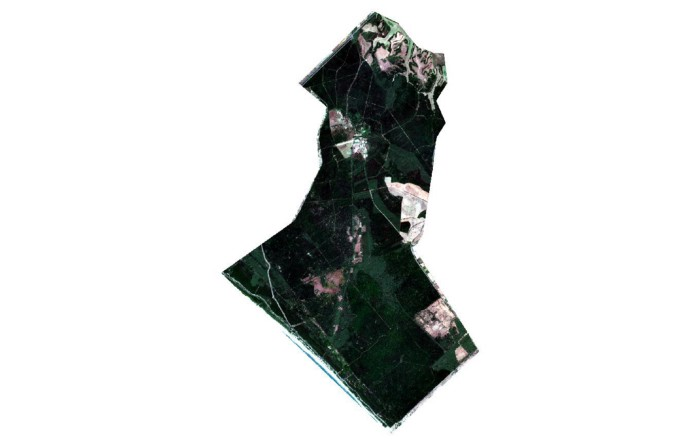

In [ ]:
Image('mask_img.jpeg')

### Create NDVI

Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

             nir - red /(nir + red)

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

### Exercise 4

    - Explain why the NDVI is defined as 

              nir - red / (nir + red)

In [ ]:
# Open b4 and b8
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b8 = rio.open(R10+'/T33TTG_20190605T100039_B08_10m.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()

# Calculate ndvi
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

The output is an NDVI image which shows vegetation level of areas in the satellite image as shown below. For example, water has low vegetation (shown red in the image).

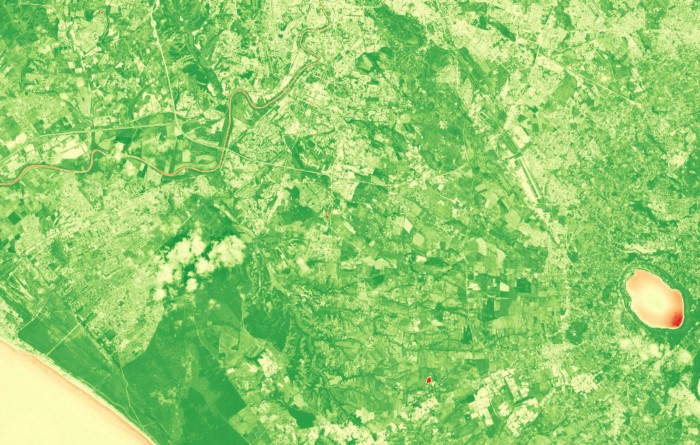

In [ ]:
Image('ndvi_img.jpeg')

## Applications of the NDVI index in farming


### How light helps in understanding plant health

Put it simply, the NDVI (Normalized difference vegetation index) is an indicator of a plant’s health based on how a plant reflects different light waves.

For example, for the human eye, a plant is green because the chlorophyll pigment in it reflects green waves. Chlorophyll also absorbs red waves and so photosynthesis occurs. In other words, a plant grows and develops. The cell structure of a plant reflects the near-infrared waves. So a healthy plant, the one with a lot of chlorophyll and good cell structure, actively absorbs red light and reflects near infrared. And exactly the opposite happens to a diseased plant. Healthy plant actively absorbs red light and reflects near infrared.

To understand the state of a plant’s health, we need to compare the values of absorption and reflection of red and infrared light. This is what the NDVI index is used for.


### What the NDVI can tell us at different stages of the season

It is important to understand that the NDVI is an indicator of the plant’s health but it says nothing about the cause of a particular condition. The vegetation index is rather a hint at what is currently happening on the field. 

Let us consider three scenarios of NDVI usage for field analysis from the OneSoil web platform which can be found in this link: https://app.onesoil.ai/?utm_source=blog&utm_medium=article&utm_campaign=what-is-ndvi&utm_content=en: 

     - at the beginning
     
     - in the middle
     
     - at end of the growing season.


### At the beginning of the season

At the beginning of the season, the NDVI index helps to understand how the plant has survived through the winter.

    i: If the NDVI is lower than 0.15, most probably all the plants died in this part of the field. Typically, these figures correspond to plowed soil without any vegetation.


    ii: 0.15−0.2 is also a low value. This may indicate that plants started wintering in the early phenological phase, before tillering.

    iii: 0.2−0.3 is a relatively good value. Probably, the plants entered the tillering stage and have resumed vegetation.


    iv: 0.3−0.5 is a good value. Nevertheless, one should keep in mind that high NDVI values can indicate that plants wintered at a late phenological stage. If the satellite image was taken before the resuming of vegetation, then it is necessary to analyze the zone after the resuming of the vegetation also.


    v: Above 0.5 is an abnormal value for the post-wintering period. It is 
       better to check this field zone yourself.


To sum up, if you see abnormal NDVI values (those that are very different from the average values for the field), you need to check this field area. You can see the NDVI index for your fields

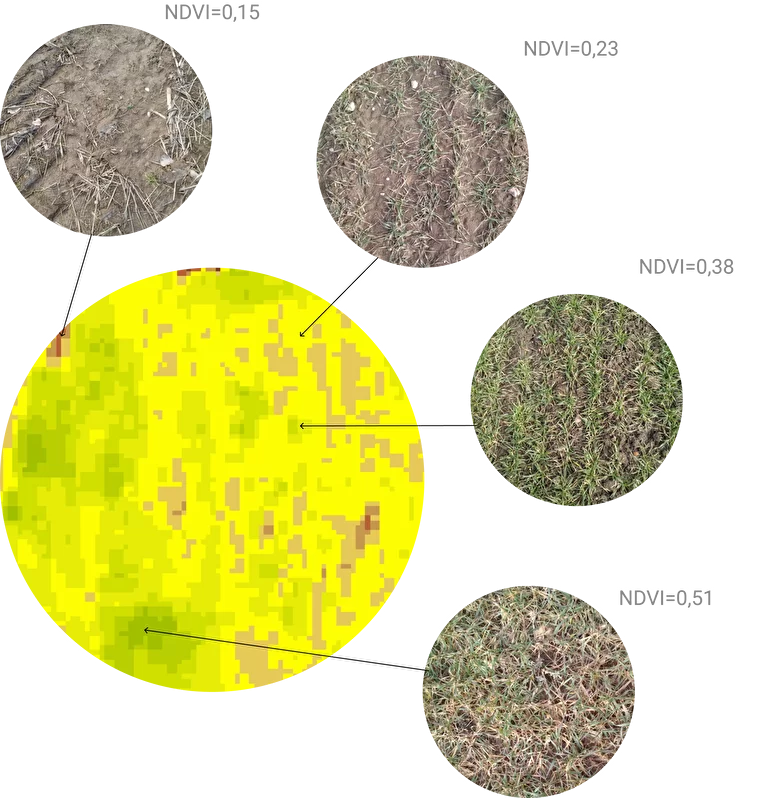

In [ ]:
Image('NDVIphoto.png')

### In the middle season

In the middle of the season, the NDVI index helps to understand how plants grow and develop. 

      - If the index values are medium to high (0.5−0.85), most likely there are no major issues at this part of the field. 
      
      - If the index is low, probably there are specific issues, like a lack of moisture or nutrients. It is better for the farmer to check this part of the field themselves.

Using the NDVI index, we create maps for variable-rate application of nitrogen. We detect areas of low, medium and high vegetation indices, and then a farmer himself can define the rate of fertilizer required. For example: the optimal nitrogen application scheme can be as follows

      1: If the vegetation index is high in the area, the fertilizer dose 
         should be reduced to 10−30% of the average rate.

      2: If the vegetation index is average, the fertilizer dose should be   
         increased up to 20−25% of the average rate.

      3: If the vegetation index is low, the farmer will need to determine the 
         cause of it first.

The NDVI index can also be used to restore the crop yield for a field. Using this information, maps for variable-rate application of phosphate and potassium fertilizers can be created.

### At the end of the season

At the end of the season, the NDVI index helps to determine which fields are ready for harvesting 

      - the lower the index, the closer the part of the field is to the ripening stage. 
      
      - The optimal index value, in this case, would be lower than 0.25.

### Pros and cons of NDVI

There are many vegetation indices, and most of them are similar to each other. But the NDVI is the most popular and widespread one, and it also has one important advantage: the high resolution of images with data from the Sentinel-2 satellite. In such cases, channels with a resolution of 10 meters are used (1 pixel is 10 by 10 meters) to calculate the NDVI index. Those indices that use additional light channels, mostly red age, have a resolution of 20 meters (1 pixel is 20 by 20 meters). 

One of the drawbacks of the NDVI is that the index loses sensitivity when a plant reaches a certain development threshold. In other words, if a plant develops very actively, it becomes impossible to distinguish an abnormally green plant from a "normally" green one. The NDVI index also depends on the weather: if clouds are overhanging a field for a long time, the satellite image will be unclear. However, this is true for any index, not just the NDVI.

### Summary

Accessing Sentinel 2 images with Python is made easy with sentinelsat. In this example, we have covered how to construct a query and retrieve on information from available images as well as how to download Sentinel 2 images within Jupyter notebooks. We have also seen how to preprocess, create RGB and NDVI images and visualize raster images with Rasterio. We have also seen the various applications of NDVI index.

### References

Please note that the majority of these notes are direct extracts from contents in the links given below

[1] https://blog.onesoil.ai/en/what-is-ndvi

[2] https://scihub.copernicus.eu/dhus/#/home

[3] https://towardsdatascience.com/satellite-imagery-access-and-analysis-in-python-jupyter-notebooks-387971ece84b